In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

In [3]:
import random as py_random
import matplotlib.pyplot as plt
import pandas as pd
import models
import warnings
warnings.filterwarnings('ignore')

<a id="etl"></a>
### ETL

In [4]:
df = pd.read_csv('data.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


Convert zip code to longtitude and latitude (making longtitude positive)

In [5]:
import zipcodes

df['zip'] = [x[3:] for x in df['statezip'] ]
df['location'] = [zipcodes.matching(x) for x in df['zip'] ]
df['lat'] = [x[0]['lat'] for x in df['location'] ]
df['long'] = [abs(x[0]['long']) for x in df['location'] ]

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,street,city,statezip,country,zip,location,lat,long
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,...,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,98133,"[{'zip_code': '98133', 'zip_code_type': 'STAND...",47.73,122.34
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,...,1921,0,709 W Blaine St,Seattle,WA 98119,USA,98119,"[{'zip_code': '98119', 'zip_code_type': 'STAND...",47.63,122.37
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,...,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,98042,"[{'zip_code': '98042', 'zip_code_type': 'STAND...",47.36,122.10
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,...,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,98008,"[{'zip_code': '98008', 'zip_code_type': 'STAND...",47.60,122.11
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,...,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,98052,"[{'zip_code': '98052', 'zip_code_type': 'STAND...",47.68,122.12


In [6]:
data = df[["price","bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","sqft_above","sqft_basement","yr_built","yr_renovated","lat","long"]]
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261,47.560878,122.199598
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536,0.134912,0.160639
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,47.100000,121.330000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,47.490000,122.100000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,47.580000,122.220000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000,47.670000,122.320000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,47.750000,122.450000


There are some price = 0 which we would like to exclude

In [7]:
data = data[data.price != 0]

Remove outliers

In [8]:
data = data[data.price < 2500000]

#### Random Forest Base Model

In [9]:
# Helper functions
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
def rmse( y, y_hat):
    return np.sqrt((1.0/len( y)) * np.sum((y - y_hat)**2))

from sklearn.model_selection import train_test_split


In [10]:
seed = 101
set_seed(seed)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','lat','long']

# Train, test, split the data
X = data[features] # Features
y = data['price'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(random_state=seed)

#Train the model using the training sets 
rfc.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = rfc.predict(X_test)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % rfc.score(X_test, y_test))
print('Decision Tree Regressor, RMSE: %f' % rmse(y_true, y_pred))

Decision Tree Regressor,  R^2: 0.727386
Decision Tree Regressor, RMSE: 179420.395352


In [11]:
def validation_curve(seed, X, y, min_val, max_val, step, test_size=0.20):
    train_scores = []
    test_scores = []
    
    for i in range(min_val, max_val + 10):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        reg = RandomForestRegressor(random_state=seed, n_estimators=i)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(rmse(y_train, y_pred))
        y_pred = reg.predict(X_test)
        test_scores.append(rmse(y_test, y_pred))
    return train_scores, test_scores

seed = 101
min_val = 10
max_val = 100
step = 10
param_range = range(min_val, max_val + step)
x_label = 'No. of Trees in RandomForest'
y_label = 'RMSE'
title = "Validation Curves for {0} to {1} trees in forest".format(min_val, max_val)

train_scores, test_scores = validation_curve(seed, X, y, min_val, max_val, step=200)

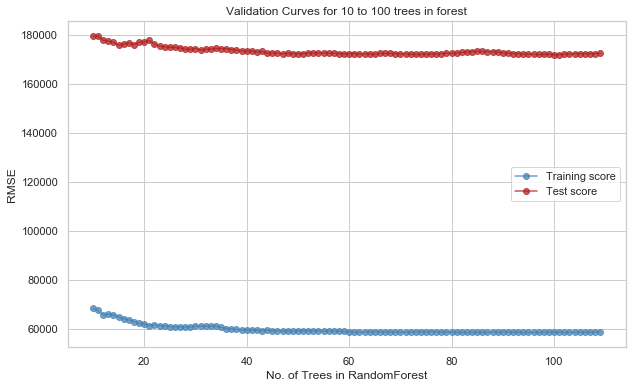

In [12]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

Adjust n_estimator to 50

In [17]:
seed = 101
set_seed(seed)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','lat','long']

# Train, test, split the data
X = data[features] # Features
y = data['price'] # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(n_estimators = 50, random_state=seed)

#Train the model using the training sets 
rfc.fit(X_train,y_train)
y_true = np.array(y_test)
y_pred = rfc.predict(X_test)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % rfc.score(X_test, y_test))
print('Decision Tree Regressor, RMSE: %f' % rmse(y_true, y_pred))

Decision Tree Regressor,  R^2: 0.748369
Decision Tree Regressor, RMSE: 172377.127302


Feature Importance

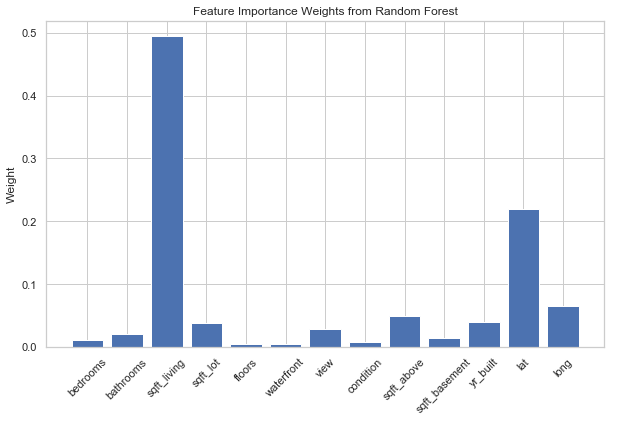

In [18]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)



axes.bar(list(range(0, len(features))), rfc.feature_importances_)
axes.set_xticks(np.arange(len(features)))
axes.set_xticklabels(features, rotation = 45)

axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Random Forest")

plt.show()
plt.close()